<a href="https://colab.research.google.com/github/cosmic643/stock-price-prediction/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import yfinance as yf

stock = yf.Ticker("RELIANCE.NS")
df = stock.history(period="1y", interval="1d")

In [3]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-06-13 00:00:00+05:30,1472.000000,1472.250000,1460.099976,1465.250000,9181160,0.0,0.0
2024-06-14 00:00:00+05:30,1470.000000,1479.675049,1457.224976,1477.550049,8157998,0.0,0.0
2024-06-18 00:00:00+05:30,1487.349976,1487.400024,1471.349976,1481.025024,7196766,0.0,0.0
2024-06-19 00:00:00+05:30,1487.500000,1487.500000,1456.000000,1458.650024,8725874,0.0,0.0
2024-06-20 00:00:00+05:30,1459.000000,1482.849976,1450.099976,1473.699951,16113776,0.0,0.0


In [4]:
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
df['Return'] = df['Close'].pct_change()
df['Lag1'] = df['Close'].shift(1)
df = df.dropna()

In [5]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA10,MA50,Return,Lag1
Date,,,,,,,,,,,
2024-08-26 00:00:00+05:30,1506.974976,1523.000000,1503.000000,1512.599976,8816114,0.0,0.0,1485.802490,1511.862007,0.008417,1499.974976
2024-08-27 00:00:00+05:30,1510.500000,1513.474976,1499.449951,1500.449951,6251156,0.0,0.0,1489.784985,1512.566006,-0.008033,1512.599976
2024-08-28 00:00:00+05:30,1505.000000,1507.474976,1493.000000,1498.300049,9610286,0.0,0.0,1493.252490,1512.981006,-0.001433,1500.449951
2024-08-29 00:00:00+05:30,1503.099976,1537.000000,1494.000000,1520.925049,38335358,0.0,0.0,1499.159998,1513.779006,0.015100,1498.300049
2024-08-30 00:00:00+05:30,1534.000000,1539.724976,1503.324951,1509.625000,41620730,0.0,0.0,1502.302502,1514.798506,-0.007430,1520.925049


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

# Example features
features = ['Lag1', 'MA10', 'MA50', 'Return']
X = df[features]
y = df['Close']

# Time series split
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print('MSE:', mean_squared_error(y_test, y_pred))


MSE: 6392.376780641076
MSE: 866.2386069355609
MSE: 509.8321309608755
MSE: 376.3186897627731
MSE: 5402.118504950111


[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


Epoch [5/20], Loss: 0.191904
Epoch [10/20], Loss: 0.096324
Epoch [15/20], Loss: 0.038744
Epoch [20/20], Loss: 0.049888


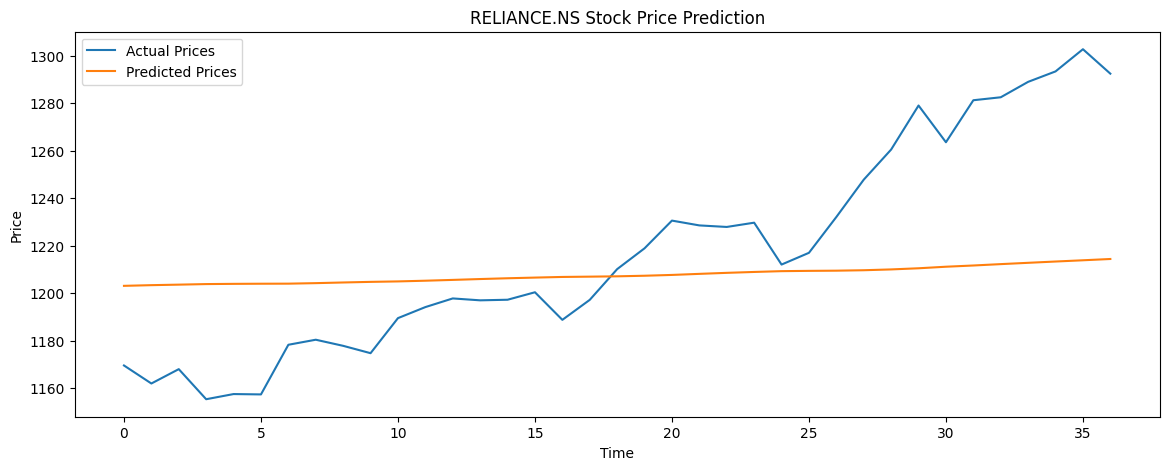

In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
sequence_length = 60
input_size = 1
hidden_size = 50
num_layers = 2
num_epochs = 20
learning_rate = 0.001

# Fetch stock data
ticker = 'RELIANCE.NS'
df = yf.download(ticker, start='2023-01-01', end='2024-01-01', interval='1d')

# Preprocessing
data = df[['Close']].values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(scaled_data, sequence_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

# Reshape for LSTM (batch_size, seq_length, input_size)
X_train = X_train.reshape(-1, sequence_length, input_size)
X_test = X_test.reshape(-1, sequence_length, input_size)

# LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_size, hidden_size, num_layers).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()

    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

# Testing
model.eval()
predicted = model(X_test).detach().cpu().numpy()
y_test = y_test.cpu().numpy()

# Inverse transform
predicted = scaler.inverse_transform(predicted)
y_test = scaler.inverse_transform(y_test)

# Plotting
plt.figure(figsize=(14,5))
plt.plot(y_test, label='Actual Prices')
plt.plot(predicted, label='Predicted Prices')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed

Using Device: cuda
Downloaded 1336 days of data for RELIANCE.NS
After removing NaN values: 1311 days
Created 1251 sequences
Training samples: 875
Validation samples: 187
Test samples: 189
Starting training...


Epoch [10/50], Train Loss: 0.002743, Val Loss: 0.000636
Epoch [20/50], Train Loss: 0.002143, Val Loss: 0.000711
Epoch [30/50], Train Loss: 0.001949, Val Loss: 0.000633
Epoch [40/50], Train Loss: 0.001814, Val Loss: 0.000339
Epoch [50/50], Train Loss: 0.001569, Val Loss: 0.000922

Evaluation Metrics:
MSE: 4102.1724
RMSE: 64.0482
MAE: 56.0955
MAPE: 4.0918


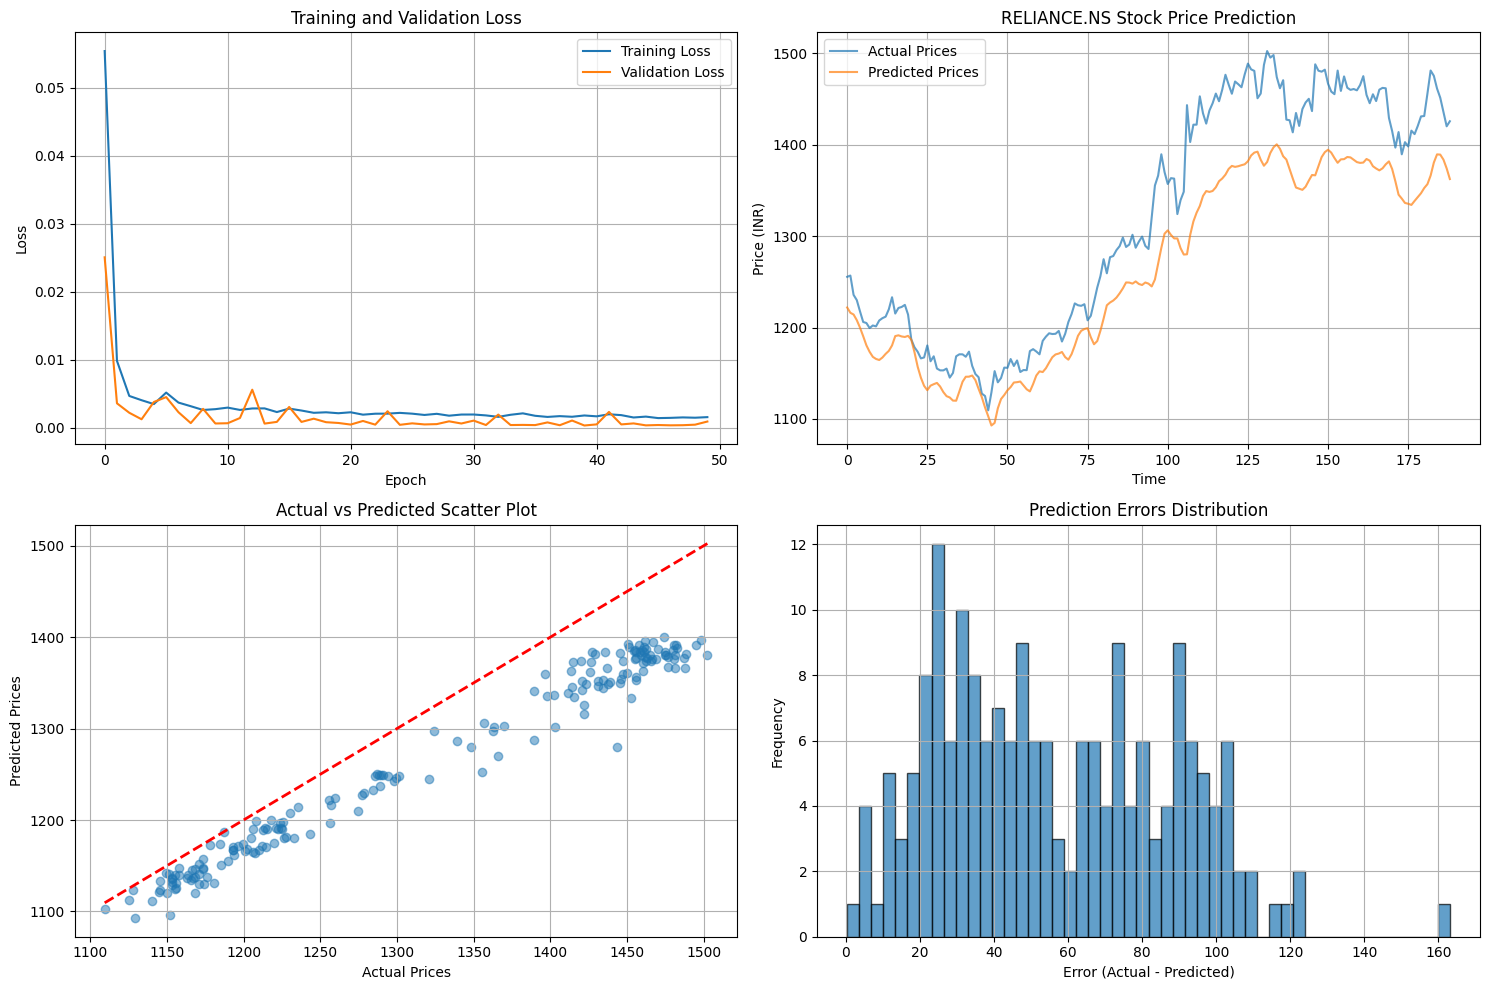


Sample Predictions (Last 10 days):
Actual     Predicted  Error      Percentage Error
------------------------------
1430.84    1346.85    83.99      5.870235443115234
1431.27    1352.53    78.74      5.5011701583862305
1455.71    1356.73    98.98      6.799139022827148
1481.02    1366.18    114.84     7.754416465759277
1475.24    1380.35    94.90      6.432699203491211
1461.29    1389.32    71.97      4.925205707550049
1451.27    1389.08    62.19      4.28544807434082
1435.90    1383.59    52.31      3.6429603099823
1420.03    1374.01    46.02      3.2408459186553955
1425.56    1362.36    63.20      4.433559417724609


In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from ta.momentum import RSIIndicator
from ta.trend import MACD, EMAIndicator
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using Device:", device)

# Hyperparameters
sequence_length = 60  # Reduced from 100 for better performance
input_size = 7  # Open, High, Low, Close, Volume, RSI, MACD
hidden_size = 128
num_layers = 3  # Reduced from 3 to prevent overfitting
num_epochs = 50
learning_rate = 0.001
batch_size = 32

def load_and_prepare_data(ticker, start_date, end_date):
    """Load and prepare stock data with technical indicators"""
    try:
        # Load data
        df = yf.download(ticker, start=start_date, end=end_date, interval='1d')

        if df.empty:
            raise ValueError(f"No data found for ticker {ticker}")

        print(f"Downloaded {len(df)} days of data for {ticker}")

        # Ensure Close is a Series (flatten if needed)
        if isinstance(df['Close'], pd.DataFrame):
            df['Close'] = df['Close'].iloc[:, 0]

        # Calculate technical indicators - pass Series, not DataFrame
        close_series = df['Close'].squeeze()  # Ensure it's a Series

        df['RSI'] = RSIIndicator(close=close_series, window=14).rsi()
        macd = MACD(close=close_series)
        df['MACD'] = macd.macd()
        df['EMA'] = EMAIndicator(close=close_series, window=20).ema_indicator()

        # Drop NaN values
        df = df.dropna()
        print(f"After removing NaN values: {len(df)} days")

        if len(df) < sequence_length + 50:  # Ensure we have enough data
            raise ValueError(f"Not enough data after preprocessing. Need at least {sequence_length + 50} samples, got {len(df)}")

        return df

    except Exception as e:
        print(f"Error loading data: {e}")
        import traceback
        traceback.print_exc()
        return None

def create_sequences(data, target, seq_length):
    """Create sequences for LSTM training"""
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = target[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

def create_data_loader(X, y, batch_size, shuffle=True):
    """Create DataLoader for batch processing"""
    dataset = torch.utils.data.TensorDataset(X, y)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

class ImprovedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(ImprovedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initialize hidden states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))

        # Take the last time step output
        out = self.dropout(out[:, -1, :])
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)

        return out

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """Training loop with validation"""
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y.squeeze())
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X).squeeze()
                loss = criterion(outputs, batch_y.squeeze())
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    return train_losses, val_losses

def calculate_metrics(actual, predicted):
    """Calculate evaluation metrics"""
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

# Main execution
if __name__ == "__main__":
    # Load data
    ticker = 'RELIANCE.NS'
    df = load_and_prepare_data(ticker, '2019-01-01', '2024-06-01')

    if df is None:
        print("Failed to load data. Exiting.")
        exit()

    # Check if we have all required columns
    required_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD']
    missing_columns = [col for col in required_columns if col not in df.columns]

    if missing_columns:
        print(f"Missing columns: {missing_columns}")
        print("Available columns:", df.columns.tolist())
        exit()

    # Prepare features
    features = df[required_columns].values

    # Check for any remaining NaN values
    if np.isnan(features).any():
        print("Warning: NaN values found in features. Removing...")
        nan_mask = ~np.isnan(features).any(axis=1)
        features = features[nan_mask]
        df = df[nan_mask]
        print(f"After removing NaN rows: {len(features)} samples")

    # Scale features
    feature_scaler = MinMaxScaler()
    scaled_features = feature_scaler.fit_transform(features)

    # Prepare target (Close prices)
    close_prices = df['Close'].values.reshape(-1, 1)
    close_scaler = MinMaxScaler()
    scaled_close = close_scaler.fit_transform(close_prices)

    # Create sequences
    X, y = create_sequences(scaled_features, scaled_close.flatten(), sequence_length)
    print(f"Created {len(X)} sequences")

    if len(X) < 100:  # Minimum sequences needed for training
        print(f"Not enough sequences for training. Need at least 100, got {len(X)}")
        exit()

    # Train-validation-test split (70-15-15)
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)

    X_train = X[:train_size]
    y_train = y[:train_size]
    X_val = X[train_size:train_size + val_size]
    y_val = y[train_size:train_size + val_size]
    X_test = X[train_size + val_size:]
    y_test = y[train_size + val_size:]

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Test samples: {len(X_test)}")

    # Convert to tensors
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_val = torch.from_numpy(X_val).float()
    y_val = torch.from_numpy(y_val).float()
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()

    # Create data loaders
    train_loader = create_data_loader(X_train, y_train, batch_size)
    val_loader = create_data_loader(X_val, y_val, batch_size, shuffle=False)
    test_loader = create_data_loader(X_test, y_test, batch_size, shuffle=False)

    # Initialize model
    model = ImprovedLSTM(input_size, hidden_size, num_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Train model
    print("Starting training...")
    train_losses, val_losses = train_model(model, train_loader, val_loader,
                                         criterion, optimizer, num_epochs, device)

    # Evaluate on test set
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X).cpu().numpy()
            predictions.extend(outputs.flatten())
            actuals.extend(batch_y.numpy().flatten())

    # Convert back to original scale
    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)

    predicted_prices = close_scaler.inverse_transform(predictions).flatten()
    actual_prices = close_scaler.inverse_transform(actuals).flatten()

    # Calculate metrics
    metrics = calculate_metrics(actual_prices, predicted_prices)
    print("\nEvaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Plot results
    plt.figure(figsize=(15, 10))

    # Plot 1: Training and validation loss
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Actual vs Predicted prices
    plt.subplot(2, 2, 2)
    plt.plot(actual_prices, label='Actual Prices', alpha=0.7)
    plt.plot(predicted_prices, label='Predicted Prices', alpha=0.7)
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price (INR)')
    plt.legend()
    plt.grid(True)

    # Plot 3: Scatter plot of actual vs predicted
    plt.subplot(2, 2, 3)
    plt.scatter(actual_prices, predicted_prices, alpha=0.5)
    plt.plot([actual_prices.min(), actual_prices.max()],
             [actual_prices.min(), actual_prices.max()], 'r--', lw=2)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs Predicted Scatter Plot')
    plt.grid(True)

    # Plot 4: Prediction errors
    plt.subplot(2, 2, 4)
    errors = actual_prices - predicted_prices
    plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
    plt.title('Prediction Errors Distribution')
    plt.xlabel('Error (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print some sample predictions
    print(f"\nSample Predictions (Last 10 days):")
    print(f"{'Actual':<10} {'Predicted':<10} {'Error':<10} {'Percentage Error':<10}")
    print("-" * 30)
    for i in range(-10, 0):
        error = actual_prices[i] - predicted_prices[i]
        print(f"{actual_prices[i]:<10.2f} {predicted_prices[i]:<10.2f} {error:<10.2f} {(abs(predicted_prices[i]-actual_prices[i])*100)/actual_prices[i]}")

Using Device: cuda
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Downloaded 1336 days of data for RELIANCE.NS
After removing NaN values: 1311 days
Created 1251 sequences
Training samples: 875
Validation samples: 187
Test samples: 189
Starting enhanced training...
Epoch [10/100], Train Loss: 0.313829, Val Loss: 0.193696, LR: 0.000500
Epoch [20/100], Train Loss: 0.296005, Val Loss: 0.214143, LR: 0.000500
Epoch [30/100], Train Loss: 0.273060, Val Loss: 0.187696, LR: 0.000250
Early stopping at epoch 32
Shape of predicted_returns before final price calculation: (189, 1)
Shape of base_prices before final price calculation: (189, 1)
Shape of predicted_prices after calculation: (189, 1)
Shape of actual_prices after reshape: (189, 1)

Enhanced Evaluation Metrics:
MSE: 245.1909
RMSE: 15.6586
MAE: 11.2529
MAPE: 0.8410
Directional_Accuracy: 48.4043
Correlation: 0.9924


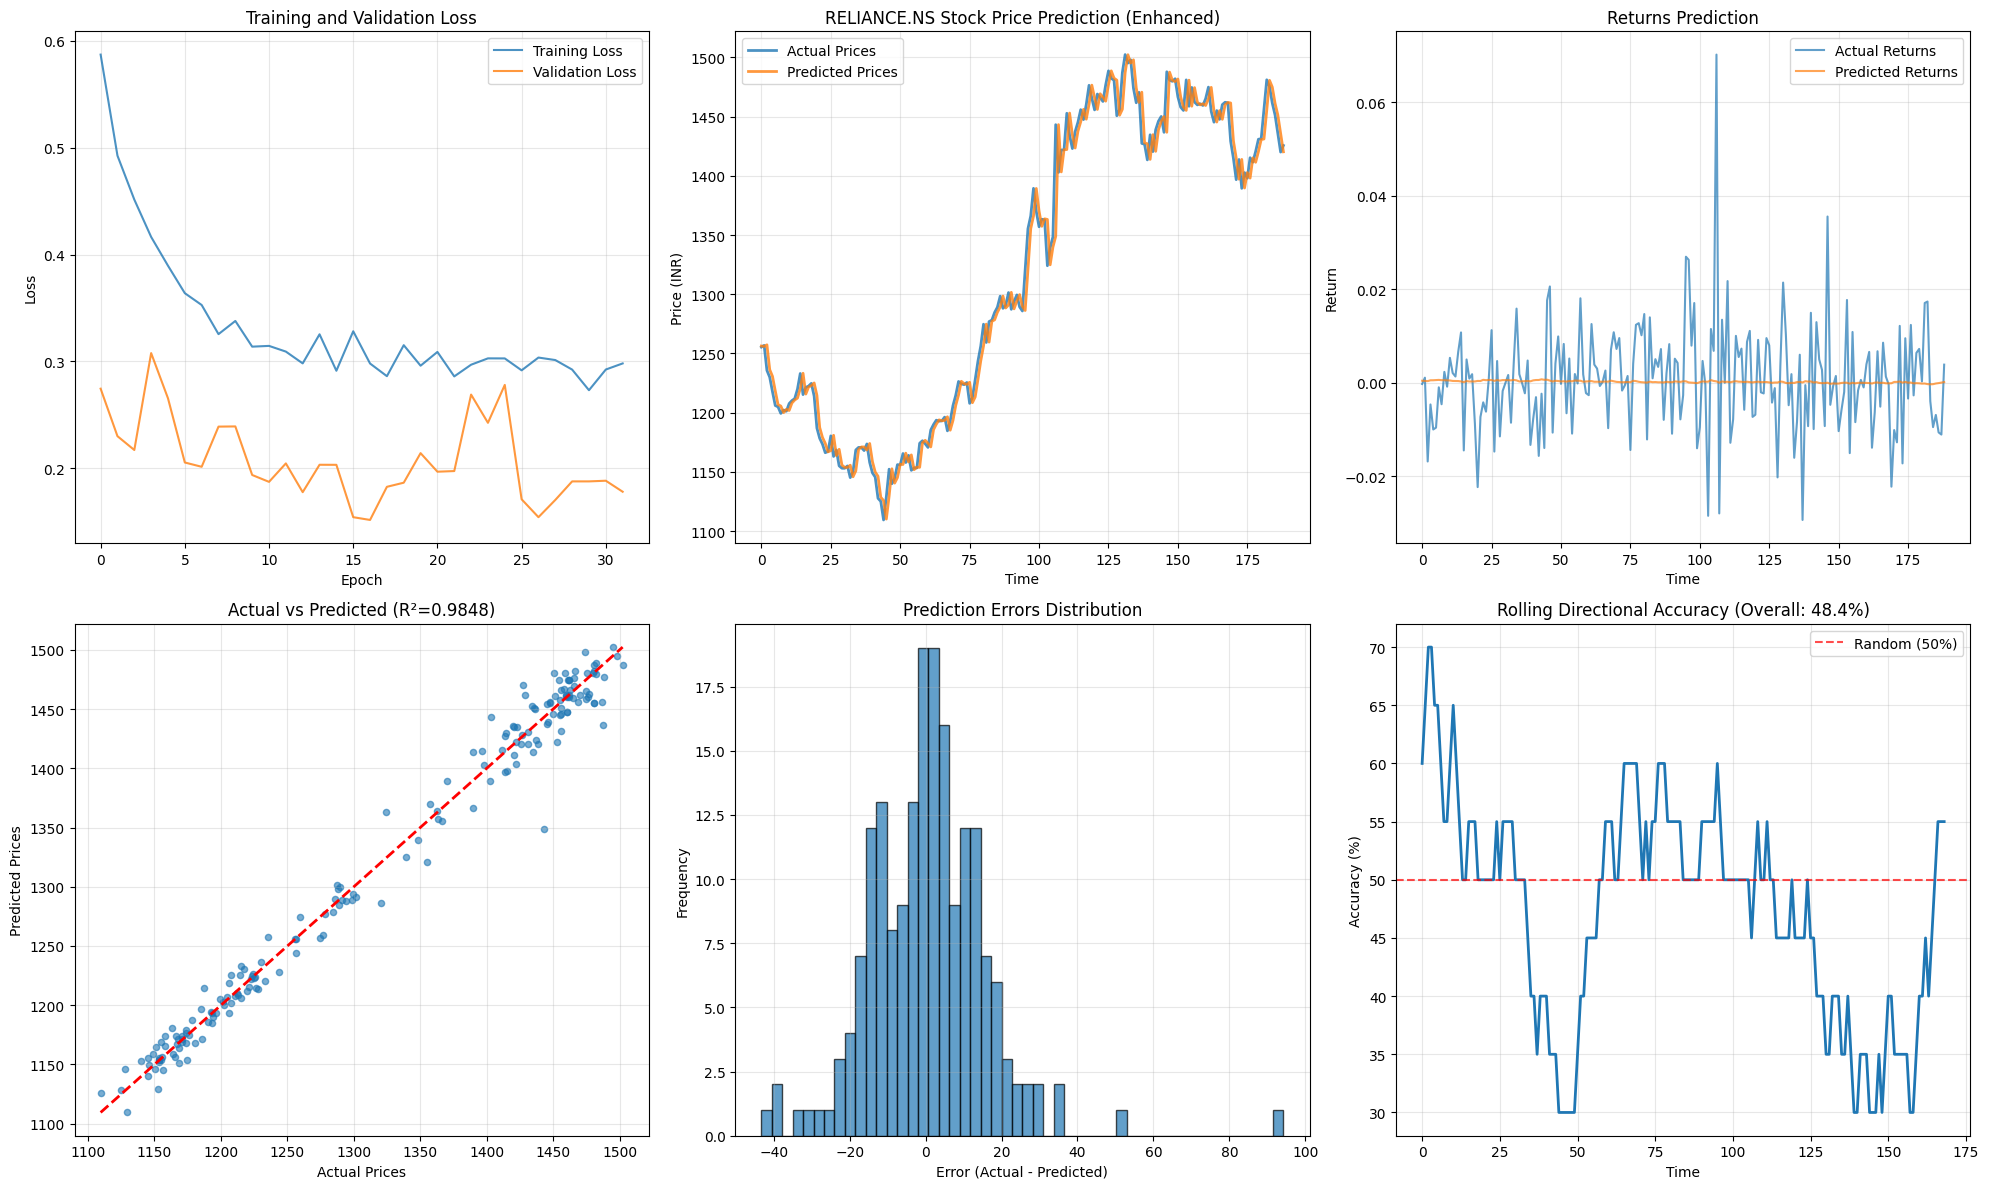


Sample Predictions (Last 10 days):
Actual     Predicted  Error      Return_A   Return_P  
------------------------------------------------------------
1430.84    1420.40    10.45      0.73      % -0.01     %
1431.27    1430.61    0.66       0.03      % -0.02     %
1455.71    1431.07    24.64      1.71      % -0.01     %
1481.02    1455.32    25.70      1.74      % -0.03     %
1475.24    1480.56    -5.32      -0.39     % -0.03     %
1461.29    1474.83    -13.54     -0.95     % -0.03     %
1451.27    1461.10    -9.82      -0.69     % -0.01     %
1435.90    1451.20    -15.30     -1.06     % -0.00     %
1420.03    1436.00    -15.97     -1.11     % 0.01      %
1425.56    1420.26    5.30       0.39      % 0.02      %

Model Performance Summary:
Average Absolute Error: ₹11.25
Average Percentage Error: 0.84%
Price Prediction Accuracy: 99.16%
Directional Accuracy: 48.40%
Price Correlation: 0.9924


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from ta.momentum import RSIIndicator
from ta.trend import MACD, EMAIndicator
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using Device:", device)

# Enhanced Hyperparameters
sequence_length = 60
input_size = 8  # Added one more feature
hidden_size = 128
num_layers = 2
num_epochs = 100  # Increased epochs
learning_rate = 0.0005  # Reduced learning rate
batch_size = 32
dropout = 0.3

def load_and_prepare_data(ticker, start_date, end_date):
    """Load and prepare stock data with enhanced technical indicators"""
    try:
        # Load data
        df = yf.download(ticker, start=start_date, end=end_date, interval='1d')

        if df.empty:
            raise ValueError(f"No data found for ticker {ticker}")

        print(f"Downloaded {len(df)} days of data for {ticker}")

        # Ensure Close is a Series
        if isinstance(df['Close'], pd.DataFrame):
            df['Close'] = df['Close'].iloc[:, 0]

        # Calculate enhanced technical indicators
        close_series = df['Close'].squeeze()

        # Original indicators
        df['RSI'] = RSIIndicator(close=close_series, window=14).rsi()
        macd = MACD(close=close_series)
        df['MACD'] = macd.macd()
        df['EMA'] = EMAIndicator(close=close_series, window=20).ema_indicator()

        # Add price change percentage (new feature)
        df['Price_Change_Pct'] = df['Close'].pct_change() * 100

        # Drop NaN values
        df = df.dropna()
        print(f"After removing NaN values: {len(df)} days")

        if len(df) < sequence_length + 50:
            raise ValueError(f"Not enough data after preprocessing. Need at least {sequence_length + 50} samples, got {len(df)}")

        return df

    except Exception as e:
        print(f"Error loading data: {e}")
        import traceback
        traceback.print_exc()
        return None

def create_sequences_with_returns(data, close_data, seq_length, predict_returns=True):
    """Create sequences with option to predict returns instead of absolute prices"""
    xs, ys = [], []

    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]

        if predict_returns:
            # Predict return (percentage change) instead of absolute price
            current_price = close_data[i + seq_length - 1]
            next_price = close_data[i + seq_length]
            y = (next_price - current_price) / current_price  # Return
        else:
            y = close_data[i + seq_length]  # Absolute price

        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

def create_data_loader(X, y, batch_size, shuffle=True):
    """Create DataLoader for batch processing"""
    dataset = torch.utils.data.TensorDataset(X, y)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

class CombinedLoss(nn.Module):
    """Combined loss function for better prediction accuracy"""
    def __init__(self, mse_weight=0.7, directional_weight=0.3):
        super(CombinedLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.mse_weight = mse_weight
        self.directional_weight = directional_weight

    def forward(self, pred, actual):
        # MSE Loss
        mse_loss = self.mse(pred, actual)

        # Directional accuracy loss
        if len(pred) > 1:
            pred_diff = pred[1:] - pred[:-1]
            actual_diff = actual[1:] - actual[:-1]

            # Encourage correct directional predictions
            directional_accuracy = torch.mean(torch.sign(pred_diff) * torch.sign(actual_diff))
            directional_loss = 1 - directional_accuracy  # Convert to loss (higher is worse)
        else:
            directional_loss = 0

        return self.mse_weight * mse_loss + self.directional_weight * directional_loss

class ImprovedLSTM(nn.Module):
    """Enhanced LSTM with residual connections and attention"""
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.3):
        super(ImprovedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Main LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Attention mechanism (simplified)
        self.attention = nn.Linear(hidden_size, 1)

        # Residual connection
        self.residual = nn.Linear(input_size, hidden_size)

        # Output layers
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.fc3 = nn.Linear(hidden_size // 4, 1)

        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(hidden_size // 2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size // 4)

    def forward(self, x):
        batch_size = x.size(0)

        # Initialize hidden states
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # LSTM forward pass
        lstm_out, _ = self.lstm(x, (h0, c0))

        # Simple attention mechanism
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        attended_output = torch.sum(attention_weights * lstm_out, dim=1)

        # Residual connection from last input
        residual = self.residual(x[:, -1, :])

        # Combine LSTM output with residual
        combined = attended_output + residual

        # Output layers with batch normalization
        out = self.dropout(combined)
        out = self.relu(self.fc1(out))
        out = self.batch_norm1(out)
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.batch_norm2(out)
        out = self.dropout(out)
        out = self.fc3(out)

        return out

def train_model_enhanced(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    """Enhanced training loop with early stopping and learning rate scheduling"""
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 15  # Early stopping patience

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y.squeeze())
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X).squeeze()
                loss = criterion(outputs, batch_y.squeeze())
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        if (epoch + 1) % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, LR: {current_lr:.6f}')

    return train_losses, val_losses

def calculate_enhanced_metrics(actual, predicted):
    """Calculate comprehensive evaluation metrics"""
    # Ensure both arrays have the same shape (n_samples, 1) for metrics expecting 2D input
    actual_reshaped = actual.reshape(-1, 1)
    predicted_reshaped = predicted.reshape(-1, 1)

    mse = mean_squared_error(actual_reshaped, predicted_reshaped)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_reshaped, predicted_reshaped)

    # Handle division by zero in MAPE
    # Use actual_reshaped for element-wise division
    mape = np.mean(np.abs((actual_reshaped - predicted_reshaped) / (actual_reshaped + 1e-8))) * 100

    # Directional accuracy (uses flattened arrays)
    actual_direction = np.sign(np.diff(actual.flatten()))
    pred_direction = np.sign(np.diff(predicted.flatten()))
    # Ensure both arrays have the same length after diff
    min_len = min(len(actual_direction), len(pred_direction))
    directional_accuracy = np.mean(actual_direction[:min_len] == pred_direction[:min_len]) * 100

    # Correlation (uses flattened arrays)
    correlation = np.corrcoef(actual.flatten(), predicted.flatten())[0, 1]

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'Directional_Accuracy': directional_accuracy,
        'Correlation': correlation
    }

# Main execution
if __name__ == "__main__":
    # Load data
    ticker = 'RELIANCE.NS'
    df = load_and_prepare_data(ticker, '2019-01-01', '2024-06-01')

    if df is None:
        print("Failed to load data. Exiting.")
        exit()

    # Check required columns
    required_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'Price_Change_Pct']
    missing_columns = [col for col in required_columns if col not in df.columns]

    if missing_columns:
        print(f"Missing columns: {missing_columns}")
        print("Available columns:", df.columns.tolist())
        exit()

    # Prepare features (now includes Price_Change_Pct)
    features = df[required_columns].values

    # Check for NaN values
    if np.isnan(features).any():
        print("Warning: NaN values found in features. Removing...")
        nan_mask = ~np.isnan(features).any(axis=1)
        features = features[nan_mask]
        df = df[nan_mask]
        print(f"After removing NaN rows: {len(features)} samples")

    # Scale features
    feature_scaler = MinMaxScaler()
    scaled_features = feature_scaler.fit_transform(features)

    # Prepare target - we'll predict returns instead of absolute prices
    close_prices = df['Close'].values

    # Create sequences (predicting returns)
    X, y = create_sequences_with_returns(scaled_features, close_prices, sequence_length, predict_returns=True)
    print(f"Created {len(X)} sequences")

    if len(X) < 100:
        print(f"Not enough sequences for training. Need at least 100, got {len(X)}")
        exit()

    # Train-validation-test split (70-15-15)
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)

    X_train = X[:train_size]
    y_train = y[:train_size]
    X_val = X[train_size:train_size + val_size]
    y_val = y[train_size:train_size + val_size]
    X_test = X[train_size + val_size:]
    y_test = y[train_size + val_size:]

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Test samples: {len(X_test)}")

    # Convert to tensors
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_val = torch.from_numpy(X_val).float()
    y_val = torch.from_numpy(y_val).float()
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()

    # Create data loaders
    train_loader = create_data_loader(X_train, y_train, batch_size)
    val_loader = create_data_loader(X_val, y_val, batch_size, shuffle=False)
    test_loader = create_data_loader(X_test, y_test, batch_size, shuffle=False)

    # Initialize enhanced model
    model = ImprovedLSTM(input_size, hidden_size, num_layers, dropout).to(device)

    # Enhanced training setup
    criterion = CombinedLoss(mse_weight=0.7, directional_weight=0.3)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

    # Train model
    print("Starting enhanced training...")
    train_losses, val_losses = train_model_enhanced(model, train_loader, val_loader,
                                                   criterion, optimizer, scheduler, num_epochs, device)

    # Evaluate on test set
    model.eval()
    predicted_returns = []
    actual_returns = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X).cpu().numpy()
            predicted_returns.extend(outputs)

            actual_returns.extend(batch_y.numpy().flatten())

    predicted_returns = np.array(predicted_returns)
    actual_returns = np.array(actual_returns)

    # Convert returns back to prices
    test_start_idx = train_size + val_size + sequence_length
    # Ensure test_start_idx does not exceed the bounds of close_prices
    test_start_idx = min(test_start_idx, len(close_prices) - len(predicted_returns))
    test_prices = close_prices[test_start_idx:test_start_idx + len(predicted_returns)]
    base_prices = close_prices[test_start_idx - 1:test_start_idx - 1 + len(predicted_returns)]

    print("Shape of predicted_returns before final price calculation:", predicted_returns.shape)
    print("Shape of base_prices before final price calculation:", base_prices.shape)

    # Convert predicted returns to prices
    # Ensure predicted_returns and base_prices are 2D arrays with shape (n_samples, 1) for correct element-wise multiplication
    predicted_prices = base_prices.reshape(-1, 1) * (1 + predicted_returns.reshape(-1, 1))
    actual_prices = test_prices.reshape(-1, 1) # Ensure actual_prices is also 2D

    print("Shape of predicted_prices after calculation:", predicted_prices.shape)
    print("Shape of actual_prices after reshape:", actual_prices.shape)


    # Calculate metrics
    metrics = calculate_enhanced_metrics(actual_prices, predicted_prices)
    print("\nEnhanced Evaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Enhanced visualization
    plt.figure(figsize=(20, 12))

    # Plot 1: Training and validation loss
    plt.subplot(2, 3, 1)
    plt.plot(train_losses, label='Training Loss', alpha=0.8)
    plt.plot(val_losses, label='Validation Loss', alpha=0.8)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Actual vs Predicted prices
    plt.subplot(2, 3, 2)
    plt.plot(actual_prices, label='Actual Prices', alpha=0.8, linewidth=2)
    plt.plot(predicted_prices, label='Predicted Prices', alpha=0.8, linewidth=2)
    plt.title(f'{ticker} Stock Price Prediction (Enhanced)')
    plt.xlabel('Time')
    plt.ylabel('Price (INR)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Returns comparison
    plt.subplot(2, 3, 3)
    plt.plot(actual_returns, label='Actual Returns', alpha=0.7)
    plt.plot(predicted_returns.flatten(), label='Predicted Returns', alpha=0.7) # Flatten for plotting only
    plt.title('Returns Prediction')
    plt.xlabel('Time')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 4: Scatter plot
    plt.subplot(2, 3, 4)
    plt.scatter(actual_prices.flatten(), predicted_prices.flatten(), alpha=0.6, s=20)
    plt.plot([actual_prices.min(), actual_prices.max()],
             [actual_prices.min(), actual_prices.max()], 'r--', lw=2)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'Actual vs Predicted (R²={metrics["Correlation"]**2:.4f})')
    plt.grid(True, alpha=0.3)

    # Plot 5: Prediction errors
    plt.subplot(2, 3, 5)
    errors = actual_prices.flatten() - predicted_prices.flatten()
    plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
    plt.title('Prediction Errors Distribution')
    plt.xlabel('Error (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    # Plot 6: Directional accuracy
    plt.subplot(2, 3, 6)
    actual_direction = np.sign(np.diff(actual_prices.flatten())) # Flatten for diff
    pred_direction = np.sign(np.diff(predicted_prices.flatten())) # Flatten for diff
    correct_direction = (actual_direction == pred_direction).astype(int)

    # Rolling directional accuracy
    window = 20
    rolling_acc = np.convolve(correct_direction, np.ones(window)/window, mode='valid')
    plt.plot(rolling_acc * 100, linewidth=2)
    plt.axhline(y=50, color='r', linestyle='--', alpha=0.7, label='Random (50%)')
    plt.title(f'Rolling Directional Accuracy (Overall: {metrics["Directional_Accuracy"]:.1f}%)')
    plt.xlabel('Time')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Enhanced sample predictions
    print(f"\nSample Predictions (Last 10 days):")
    print(f"{'Actual':<10} {'Predicted':<10} {'Error':<10} {'Return_A':<10} {'Return_P':<10}")
    print("-" * 60)
    for i in range(-10, 0):
        error = actual_prices[i, 0] - predicted_prices[i, 0]
        return_a = actual_returns[i] * 100
        return_p = predicted_returns[i, 0] * 100
        print(f"{actual_prices[i, 0]:<10.2f} {predicted_prices[i, 0]:<10.2f} {error:<10.2f} {return_a:<10.2f}% {return_p:<10.2f}%")

    # Performance summary
    print(f"\nModel Performance Summary:")
    print(f"Average Absolute Error: ₹{metrics['MAE']:.2f}")
    print(f"Average Percentage Error: {metrics['MAPE']:.2f}%")
    print(f"Price Prediction Accuracy: {100 - metrics['MAPE']:.2f}%")
    print(f"Directional Accuracy: {metrics['Directional_Accuracy']:.2f}%")
    print(f"Price Correlation: {metrics['Correlation']:.4f}")